Titanic: Machine Learning from Disaster

In [139]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('seaborn')
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [71]:
# Load Data
train = pd.read_csv("/Users/cris/Documents/Kaggle/Titanic/train.csv")
test = pd.read_csv("/Users/cris/Documents/Kaggle/Titanic/test.csv")

Survived
0    549
1    342
Name: PassengerId, dtype: int64


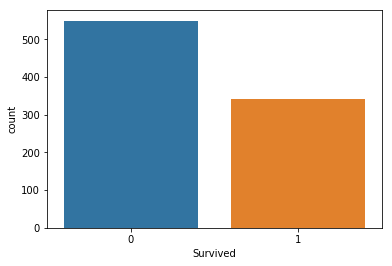

In [72]:
print(train.groupby('Survived')['PassengerId'].count())
sns.countplot('Survived', data=train)

We can see that we have 342 passengers that survived and 549 passengers that did not

In [73]:
# take a glimpse of the data
print("Train shape: {0}; Test shape: {1}".format(train.shape, test.shape))
train.head()

Train shape: (891, 12); Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [74]:
# keep the ids incase we need
train_id = train['PassengerId']
test_id = test['PassengerId']

# save Survived
Survived = train['Survived']
#train = train.drop(['Survived'], axis=1)

In [75]:
alldata = [train, test]

In [76]:
# create a function to check nulls
def check_nulls(df):
    nulls = np.sum(df.isnull())
    nullcols = nulls.loc[(nulls != 0)]
    d_types = df.dtypes.loc[(nulls != 0)]
    info = pd.concat([nullcols, d_types], axis=1).sort_values(by=0, ascending=False)
    print(info)
    print("There are", len(nullcols), "columns with missing values")
    
# use the function    
for i in alldata:
    print(check_nulls(i))
    print("------------------------")

            0        1
Cabin     687   object
Age       177  float64
Embarked    2   object
There are 3 columns with missing values
None
------------------------
         0        1
Cabin  327   object
Age     86  float64
Fare     1  float64
There are 3 columns with missing values
None
------------------------


In [77]:
## Impute NaNs

# I want to drop Cabin since majority are nulls BUT many higher tickets have names so we will keep
#titanic['Cabin'] = titanic['Cabin'].fillna('unknown')

# Embarked
# looked at the two missing and will impute where all others in space are
train.loc[train.PassengerId == 62, 'Embarked'] = "C"
train.loc[train.PassengerId == 830, 'Embarked'] = "S"

# Age
#agemed = titanic.groupby('Pclass')['Age'].transform('median')
#titanic['Age'] = titanic['Age'].fillna('unknown')

# Fare
faremed = test.groupby('Pclass')['Fare'].transform('median')
test['Fare'] = test['Fare'].fillna(faremed)

# family size
for data in alldata:
    data['Familysize'] = data['SibSp'] + data['Parch'] + 1
    
# Cabin
for data in alldata:
    data['Cabin'] = data['Cabin'].fillna('None')
    data['Cabin_letter'] = data['Cabin'].str[0]

# age
fill_list = np.arange(1, 66, 1)
for data in alldata:
    data['Age'] = data['Age'].fillna(pd.Series(np.random.choice(fill_list, size=len(train.index))))

# check again
for i in alldata:
    print(check_nulls(i))
    print("------------------------")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values
None
------------------------
Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values
None
------------------------


In [78]:
from sklearn.feature_extraction.text import CountVectorizer

# tokens
white_space = '\\S+(?=\\s+)'

vectorizer = CountVectorizer(token_pattern=white_space) # add token_pattern=white_space
train_names = vectorizer.fit_transform(train.Name) 
test_names = vectorizer.transform(test.Name)

# print the feature names 
print(vectorizer.get_feature_names()[:20])
print("There are {} tokens in Count Vectorizer".format(len(vectorizer.get_feature_names())))

['"annie', '"bessie"', '"hannah"', '"mary"', '("george', '("louis', '("mr', '("mrs', '("philip', '("william', '(ada', '(adele', '(agnes', '(alfrida', '(alice', '(alma', '(amelia', '(amy', '(anna', '(annie']
There are 1181 tokens in Count Vectorizer


**PRE-PROCESSING**

Let us turn all the categorical variables into numerical

In [79]:
from sklearn import preprocessing

# separate all the non numerical values
objects = []
for i in train.columns:
    if train[i].dtype == object:
        objects.append(i)

# apply LabelEncoder
for factor in objects:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor].astype(str))
    test[factor] = preprocessing.LabelEncoder().fit_transform(test[factor].astype(str))

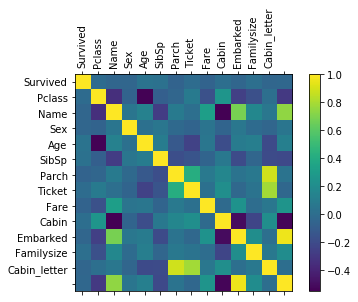

In [81]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cax = ax.matshow(train.corr(), interpolation='nearest')
fig.colorbar(cax)
ax.set_xticklabels([''] + train.columns, rotation=90)
ax.set_yticklabels([''] + train.columns)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [82]:
# get rid of columns that are irrelevent for now
cols_to_delete = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']

train = train.drop(cols_to_delete, axis=1)
test = test.drop(cols_to_delete, axis=1)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Familysize,Cabin_letter
0,0,3,1,22.0,7.2500,2,2,7
1,1,1,0,38.0,71.2833,0,2,2
2,1,3,0,26.0,7.9250,2,1,7
3,1,1,0,35.0,53.1000,2,2,2
4,0,3,1,35.0,8.0500,2,1,7


In [84]:
target = train['Survived'].values
train = train.drop('Survived', axis=1)

In [85]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

train = sc.fit_transform(train)
test = sc.fit_transform(test)

**MODELS**

In [86]:
# model selection:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# disciminant
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Evaluation
from sklearn.metrics import accuracy_score

from pprint import pprint

In [87]:
np.random.seed(7)

# KFold cross validation
kfold = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

*Logistic Regression*

In [88]:
logr = LogisticRegression()
logr_cv = cross_val_score(logr, train, Survived, cv=kfold)

print(logr_cv)
print(np.mean(logr_cv))

[0.77441077 0.76430976 0.81144781]
0.7833894500561168


**KNN**

In [89]:
knn = KNeighborsClassifier()
knn_cv = cross_val_score(knn, train, Survived, cv=kfold)

print(knn_cv)
np.mean(knn_cv)

[0.78114478 0.75420875 0.82828283]


0.787878787878788

In [90]:
# with random search

parameters = {
    "n_neighbors" : np.arange(1,10,1),
    "weights" : ['uniform', 'distance']
}

knn_cv = RandomizedSearchCV(knn, parameters, cv=kfold)
knn_cv.fit(train, Survived)

print(knn_cv.best_params_)
print(knn_cv.score(train, Survived))

knn_model = knn_cv.best_estimator_
knn_model

{'weights': 'uniform', 'n_neighbors': 4}
0.8619528619528619


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

**SVM**

In [114]:
# Create SVM classification object 
svmm = svm.SVC(kernel='linear')

parameters = {
    'C' : [.001, .01]
}

svm_cv = GridSearchCV(svmm, parameters, cv=kfold)
svm_cv.fit(train, Survived)

print(svm_cv.best_params_)
print(svm_cv.score(train, Survived))

svm_model = svm_cv.best_params_

{'C': 0.01}
0.7867564534231201


**Random Forest**

In [100]:
rfc = RandomForestClassifier(n_estimators=500) 
rfc_cv = cross_val_score(rfc, train, Survived, cv=kfold)

print(rfc_cv)
np.mean(rfc_cv)

[0.78787879 0.78114478 0.8013468 ]


0.7901234567901234

In [140]:
# Create the random grid
random_grid = {'n_estimators': [500],
               'max_depth': np.arange(30,110,10),
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': np.arange(1,5,1),
               'min_samples_split': np.arange(2,11,1),
}

pprint(random_grid)

grid = RandomizedSearchCV(rfc, random_grid, cv=kfold, n_jobs=10)
grid.fit(train, Survived)

print(grid.best_params_)
print(grid.score(train, Survived))

rf_model = grid.best_estimator_

{'max_depth': array([ 30,  40,  50,  60,  70,  80,  90, 100]),
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': array([1, 2, 3, 4]),
 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'n_estimators': [500]}
{'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90}
0.9225589225589226


*XGBoost*

In [102]:
xgb = XGBClassifier()

parameters = {
    #'objective' : ['binary'],
    'n_estimators' : [600],
    'learning_rate' : [.01],
    'min_child_weight' : [1,2,3],
    'max_depth' : [3,4,6],
    'random_state' : [69]
}

xgb_cv = GridSearchCV(xgb, parameters, cv = kfold)
xgb_cv.fit(train, Survived)

print("Best parameters: ", xgb_cv.best_params_)
print("Score: ", xgb_cv.score(train, Survived))

xgb_model = xgb_cv.best_estimator_

Best parameters:  {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 600, 'random_state': 69}
Score:  0.8922558922558923


*LGBM*

In [118]:
lgm = LGBMClassifier()

grid = {'boosting_type':['gbdt'],
        'n_estimators':[100,300,800],
        'learning_rate':[0.3,0.6,0.8],
        #'min_data_in_leaf':[15,20,35],
        #'cat_smooth':[10,20,30],
        'num_leaves':[31,40,50],
        'objective':['binary']
}

lgbm_cv = RandomizedSearchCV(lgm, grid, cv = kfold)             
lgbm_cv.fit(train,Survived)

print("Best parameters: ", lgbm_cv.best_params_)
print("Score: ", lgbm_cv.score(train, Survived))

lgb_model = lgbm_cv.best_estimator_

Best parameters:  {'objective': 'binary', 'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.3, 'boosting_type': 'gbdt'}
Score:  0.9865319865319865


In [142]:
# submission for LGB
lgb_pred = lgb_model.predict(test)

# submission
submission = pd.DataFrame(test_id)
submission['Survived'] = lgb_pred
submission.reset_index()
submission.to_csv('Titanic_submission_lgb.csv', index = 0)

# did not work, way too much overfitting

*ADA Boost*

In [136]:
ada = AdaBoostClassifier()

grid = {
    'n_estimators': [500],
    'algorithm' : ['SAMME', 'SAMME.R'],
    'learning_rate': [.001, .01, .5],
    'random_state':[69]
}

ada_cv = GridSearchCV(ada, grid, cv = kfold)
ada_cv.fit(train, Survived)

print("Best parameters: ", ada_cv.best_params_)
print("Score: ", ada_cv.score(train, Survived))

ada_model = ada_cv.best_estimator_

Best parameters:  {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 500, 'random_state': 69}
Score:  0.8204264870931538


*Gradient Boost*

In [137]:
gb = GradientBoostingClassifier()

param = {
    'learning_rate' : [.1, .2, .4, .6, .8],
    'n_estimators' : [100, 200, 400, 600],
    'min_samples_split' : [2, 3, 4, 6],
    'min_samples_leaf' : [1, 2, 4, 6, 8]
}

gb_cv = RandomizedSearchCV(gb, param, cv = kfold)
gb_cv.fit(train, Survived)

print("Best parameters: ", gb_cv.best_params_)
print("Score: ", gb_cv.score(train, Survived))

gb_model = gb_cv.best_estimator_

Best parameters:  {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 8, 'learning_rate': 0.1}
Score:  0.8843995510662177


**Voting Classifier**

Didn't use SVM since the score was very weak.

In [141]:
VC = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model), ('ada', ada_model), ('lgb', lgb_model), ('gb', gb_model), ('knn', knn_model)], voting='soft')

for clf, label in zip([rf_model, xgb_model, ada_model, lgb_model, gb_model, knn_model, VC], ['Random Forest','XGBoost','Ada Boost', 'Light GBM', 'Gradient Boosting', 'KNN', 'Ensemble']):
    scores = cross_val_score(clf, train, Survived, cv=kfold, scoring='accuracy') 
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.82 (+/- 0.03) [Random Forest]
Accuracy: 0.82 (+/- 0.01) [XGBoost]
Accuracy: 0.81 (+/- 0.02) [Ada Boost]
Accuracy: 0.79 (+/- 0.02) [Light GBM]
Accuracy: 0.82 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.80 (+/- 0.01) [KNN]
Accuracy: 0.82 (+/- 0.02) [Ensemble]


In [143]:
VC = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)], voting='soft')


# the model
prediction = VC.fit(train, Survived).predict(test)

# submission
submission = pd.DataFrame(prediction, columns=['Survived'])
submission.insert(0, 'PassengerId', test_id)
submission.reset_index()
submission.to_csv('Titanic_submission_VC.csv', index = False)

*Neural Networks*

In [ ]:
import random
random.seed(69)

In [144]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

n_cols = train.shape[1]
target = to_categorical(target)

Using TensorFlow backend.


In [153]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
early_stopping_monitor = EarlyStopping(patience=3)
my_optimizer = SGD(lr = 0.01)
model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train, target, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 623 samples, validate on 268 samples
Epoch 1/30
623/623 [==============================] - 0s 327us/step - loss: 0.7398 - acc: 0.3274 - val_loss: 0.7007 - val_acc: 0.5149
Epoch 2/30
623/623 [==============================] - 0s 75us/step - loss: 0.6822 - acc: 0.5795 - val_loss: 0.6500 - val_acc: 0.6679
Epoch 3/30
623/623 [==============================] - 0s 78us/step - loss: 0.6457 - acc: 0.6565 - val_loss: 0.6138 - val_acc: 0.6866
Epoch 4/30
623/623 [==============================] - 0s 71us/step - loss: 0.6183 - acc: 0.6806 - val_loss: 0.5880 - val_acc: 0.7052
Epoch 5/30
623/623 [==============================] - 0s 71us/step - loss: 0.5972 - acc: 0.7014 - val_loss: 0.5667 - val_acc: 0.7164
Epoch 6/30
623/623 [==============================] - 0s 69us/step - loss: 0.5795 - acc: 0.7255 - val_loss: 0.5487 - val_acc: 0.7463
Epoch 7/30
623/623 [==============================] - 0s 72us/step - loss: 0.5639 - acc: 0.7496 - val_loss: 0.5327 - val_acc: 0.7500
Epoch 8/30
623/623 [==

In [154]:
# the model
prediction = model.predict(test)
prediction = pd.DataFrame(prediction, columns=['Survived', 'Did Not'])
prediction = prediction.iloc[:,1]
#y_classes = keras.np_utils.probas_to_classes(prediction)

prediction[prediction > 0.5] = 1
prediction[prediction <= 0.5] = 0
prediction = prediction.astype(int)

In [155]:
# submission
submission = pd.DataFrame(test_id)
submission['Survived'] = prediction
submission.reset_index()
submission.to_csv('Titanic_submission.csv', index = 0)